# Introduction

We will be investigating and exploring a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) dataset for text classification. The original corpus is a set of more than a million news articles compiled by ComeToMyHead -- a news search engine. The subset we will be working with is much smaller (curated by [Xiang Zhang](https://arxiv.org/abs/1509.01626)), and it is provided through [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/ag_news_subset). These two facts make the AG Subset desirable as it will be easy to work with in terms of accessability and size. Furthermore, because the corpus is compiled from news articles I am hoping that it will contain a diverse vocabulary. In addition to this EDA I hope to also build my own word embeddings, and my thinking is that having a diverse vocabulary will make it easier to find applicable test metrics.

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Download

One may think that this would be any easy process given the established nature of TensorFlow and the fact that their documentation makes it seem like it would be easy, but good god you would be wrong. Long story short, the function to download and preprocess the AG Subset dataset results in a checksum mismatch error. Now I am no expert in checksums, but the only reason there was a mismatch was because the checksum TF expected was all caps, and that doesn't seem like a real problem. My plan is to open an issue on GitHub so they can fix it, but in the meantime I have figured out a workaround. Using the CLI that comes with the TF Datasets package run the following command from within this repository:

```
tfds build ag_news_subset --register_checksums --data_dir data
```

This should download and process the data and place it in the *data_tf* folder. The code below will then load that data for use throughout.

In [2]:
#This only works if you ran the CLI command above, or have already
#run the tfds.load command
ds, info = tfds.load('ag_news_subset', data_dir='./data_tf', download=False, with_info=True)

#This should be working now, but manual download is easiest
# ds = tfds.load('ag_news_subset', data_dir='./data_tf')

# Exploration

In [3]:
print(list(ds.keys()))

['train', 'test']


We can see that our dataset has two splits: train and test. From the TF documentation we also know that there are 120,000 examples in the training set and 7,600 examples in the test set. Next, let's examine a single training example.

In [4]:
for example in ds['train'].take(1):
    print(list(example.keys()))

['description', 'label', 'title']


In [5]:
print(example['description'],'\n')
print(example['label'],'\n')
print(example['title'])

tf.Tensor(b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.', shape=(), dtype=string) 

tf.Tensor(3, shape=(), dtype=int64) 

tf.Tensor(b'AMD Debuts Dual-Core Opteron Processor', shape=(), dtype=string)


We see that each example has three attributes: a description (a short snippet of the article), a label, and a title. The example above is from an article on a new AMD processor and is given the label "3". There are four classes, which is actually a subset from the original corpus, and they are sports, business, science and technology, and world. Thus we see that the above example falls under the science and technology category.

In [6]:
classes = ['world', 'sports', 'business', 'science/technology']

The dataset was created for the purposes of text classification, hence the labels for supervised training. Of course this doesn't prevent it from being used for building embeddings, and that is a necessary part to any text based deep learning task. We also note that for the purposes of embedding, the description and title can both be used.

One surprising thing that might stand out from the above example is the "#39;s". This appears to be indicating a 's, but it is unclear if this is a purposeful addition or if there is some error.

To investigate this further let's try loading the dataset manually to see if that fixes it.

In [35]:
train_df = pd.read_csv('data_csv/ag_news_csv/train.csv', names=['Label','Title','Description'])

#NOTE: If you didn't do manual donwload run these lines instead
# train_df = tfds.as_dataframe(ds['train'], info)
# train_df.columns = train_df.columns.str.capitalize()
# train_df = train_df[['Label', 'Title', 'Description']]
# train_df['Description'] = train_df['Description'].str.decode('utf-8');
# train_df['Title'] = train_df['Title'].str.decode('utf-8');

In [36]:
train_df.head()

,Label,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [37]:
print(train_df.loc[6, 'Description'])

AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday.


On a first glance this seems to have fixed the problem, but as we can see in the output above there are still these strange characters. Below, we have looked through our dataframe for the exact same example, and we can see that it still has the "#39;s".

In [38]:
for idx, row in train_df.iterrows():
    if 'AMD Debuts Dual-Core' in row[1]:
        print(row[2])
        break

AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.


Further research on the web has shown that 39 is the ASCII value for and apostrophe (') and 36 the ASCII value for doller sign ($), so it seems not all of the ASCII is getting properly parsed. This isn't too much of a problem as (at least for my task of embeddding) I would want to get rid of these symbols anyway.

Before we try to tackle any pre-processing lets look at the distribution of classes in our data. It is also a good time to note that when manually loading our dataset the class values range from 1-4 instead of 0-3. This explains why the examples in the df.head() output above are labeled 3 for business.

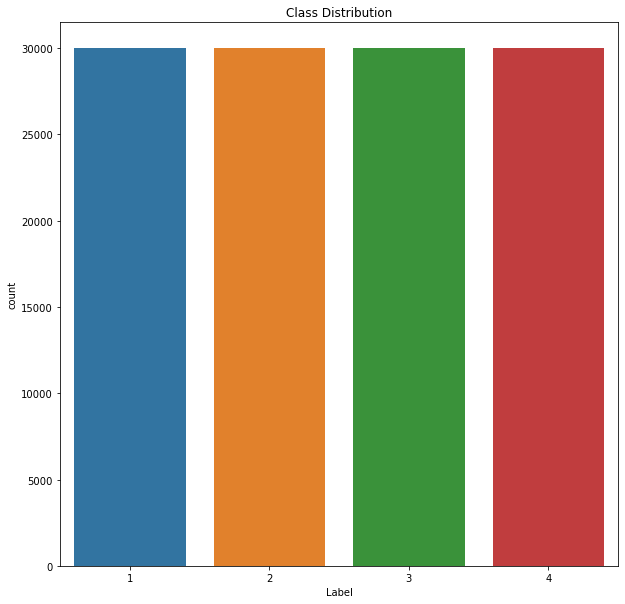

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plot = sns.countplot(x='Label', data=train_df, ax=ax)
plot.set(title='Class Distribution');

Well, this is a perfectly balanced dataset with 30,000 examples per class. Again, this doesn't so much matter for embedding, but it is good to know.

We are interested in using both the example titles and descriptions in our training, so we will reformat our dataframe to accomodate this.

In [40]:
df1 = train_df[['Label','Title']]
df2 = train_df[['Label','Description']]

df1.columns = ['Label', 'Text']
df2.columns = ['Label', 'Text']

train_df = pd.concat([df1,df2], ignore_index=True)

In [41]:
print(train_df.shape)
train_df.head()

(240000, 2)


,Label,Text
0,3,Wall St. Bears Claw Back Into the Black (Reuters)
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


We have doubled our training examples by including both the title and description as separate examples.

In [42]:
words = train_df['Text'].str.split().str.len()
print('Total number of words: ', words.sum())
print('Average number of words/example: ', words.mean())

Total number of words:  4541694
Average number of words/example:  18.923725


We can see that we have over four million words, with an average example length of about 19 words.

# Pre-Processing

Now that we have dealt with loading, examining, and re-structuring our data we are interested in processing it to prepare for learning an embedding. We need to do a number of things, most notably removing those strange ASCII character leftovers and punctuation.

In [43]:
import re #Regular expressions
import string

The following function for cleaning our text was based off the *remove_punc* function that can be found [here](https://colab.research.google.com/drive/1nh9QvDu3YgceQ2PH5DZz3pnYbGljtpIF?usp=sharing#scrollTo=Rzxp8lfO4OC5). It turns out that no modifications needed to be made in order to remove the ASCII artifacts.

In [44]:
#Remove punctuation, ASCII artifacts, and other
def clean_text(text):
    #Remove punctuation
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    #Convert to lower case
    text = text.lower()
    
    #Remove stop words
    return text

In [45]:
train_df['Text'] = train_df['Text'].apply(lambda x: clean_text(x))

In [46]:
print(train_df.loc[6+120000, 'Text'])

ap  assets of the nations retail money market mutual funds fell by   billion in the latest week to   trillion the investment company institute said thursday


We see the same exaple that we saw earlier, but now all of the ASCII artifacts (and other characters) have been removed. It has resulted in some weird white spaces, but this won't affect anything as we are only interested in the words.

# Tokenization

We have cleaned up our data by removing punctuation and other artifacts, so our next step is to configure everything to learn an embedding. To this end we need to build a vocabulary and tokenize our text data.

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams

In [23]:
T = Tokenizer()
T.fit_on_texts(train_df['Text'])

In [24]:
sample = train_df['Text'][0]
token_text = T.texts_to_sequences([sample])

print(sample)
print(token_text)

wall st bears claw back into the black reuters
[[388, 384, 1513, 14151, 98, 53, 1, 813, 22]]


Using the Keras Tokenizer we have created a vocabulary from our training data and tokenized every unique word. In the output above we can see the corresponding token sequence for a given string. It is important to point out that "the" has a token of 1, this is because it is the most frequent word in our corpus and the Keras tokenizer bases its indexing on this feature.

In [25]:
v_size = len(T.word_index)+1
print('Vocab size: ', v_size)

Vocab size:  89903


We see that our total vocab size is just under 90,000 unique words. In practice it might make sense to limit this as some of the less frequent words are not important.

In [26]:
counts = sorted([count for key, count in T.word_counts.items()], reverse=True)

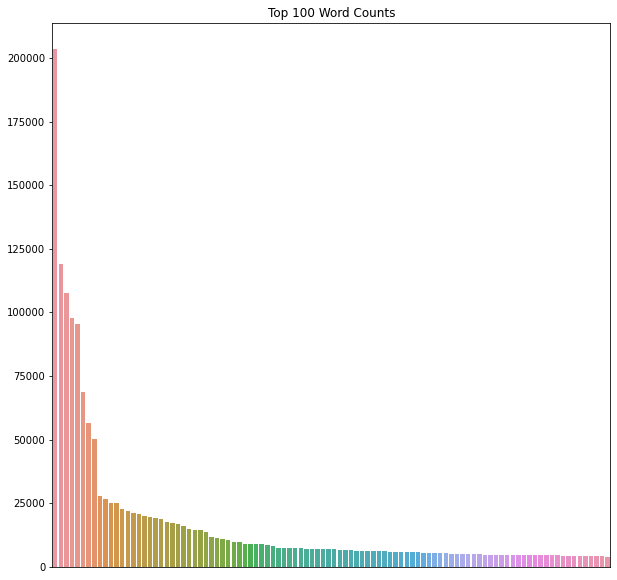

In [27]:
n = 100
x = np.arange(1, n+1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
plot = sns.barplot(x=x, y=counts[:n], ax=ax)
plot.set(xticklabels=[])
plot.set(xlabel=None)
plot.tick_params(bottom=False)
plot.set(title='Top 100 Word Counts');

In the plot above we can see the top 100 word counts from our corpus. We can see that the counts decay quite rapidly, and in general there is a very long tail. This highlights the importance of frequency based sampling in order to prevent biases towards more common words.

The final piece we are interested in is how to transform our tokenized examples into inputs that just consider a windowed context around a given word. To do this we can use the following function from TensorFlow:

In [28]:
couples,_ = skipgrams(token_text[0], v_size, window_size=2, negative_samples=0.0, shuffle=False)
print(sample,'\n')
print(token_text,'\n')
print(couples)

wall st bears claw back into the black reuters 

[[388, 384, 1513, 14151, 98, 53, 1, 813, 22]] 

[[388, 384], [388, 1513], [384, 388], [384, 1513], [384, 14151], [1513, 388], [1513, 384], [1513, 14151], [1513, 98], [14151, 384], [14151, 1513], [14151, 98], [14151, 53], [98, 1513], [98, 14151], [98, 53], [98, 1], [53, 14151], [53, 98], [53, 1], [53, 813], [1, 98], [1, 53], [1, 813], [1, 22], [813, 53], [813, 1], [813, 22], [22, 1], [22, 813]]


We have generated sets of skip-grams from the tokenized example we saw above. We have a window of 2 so we look two positions on other side of a target word, and we have not included negative samples. We can see that the first pair corresponds to "wall st", and the second "wall bears". 

# Conclusion

We have gone through a lot of processes on our AG Subset dataset. The next step is to streamline all of this so that it can be applied before some deep learning task. The work done here will make that task much easier, and not only for this dataset. In future work I will be able to focus on the learning, and less of the dataset preparation. 